<a href="https://colab.research.google.com/github/tsholofelo-mokheleli/xAI-gender-based-mental-health-analysis/blob/main/age-diabetes-development-xai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Model Development**

In [15]:
# Load the librarys
import pandas  as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import psutil
import os

# Filter warnings
import warnings
warnings.filterwarnings('ignore')

# Data split
from sklearn.model_selection import train_test_split

# Metrics
from sklearn.metrics import precision_score, recall_score, f1_score,balanced_accuracy_score
from imblearn.metrics import geometric_mean_score

# Class Imbalance
from imblearn.over_sampling import SMOTE

# Classifiers
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Hyper-parameter tuning
from sklearn.model_selection import GridSearchCV

# Cross Validation
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.base import clone

# xAI
import shap

In [16]:
plt.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 600,
    "font.size": 12,
    "axes.labelsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "axes.titlesize": 12,
    "pdf.fonttype": 42,
    "ps.fonttype": 42
})
sns.set_style("white")
sns.set_context("paper", font_scale=1.2)

export_png = True

out_dir = "figures"
os.makedirs(out_dir, exist_ok=True)

def safe_name(s: str) -> str:
    return "".join(c if (c.isalnum() or c in "-_") else "_" for c in s).strip("_")

### **Load dataset**

In [17]:
data = pd.read_csv("Diabetes health indicators Binary.csv")

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [19]:
data.shape

(253680, 22)

### **Stratified Training**

When we split the data into Training and Testing sets, we must ensure both sets have the exact same proportion of Men/Women and Diagnosed/Not-Diagnosed as the original.

In [20]:
data['stratify_col'] = data['Sex'].astype(str) + "_" + data['Diabetes_binary'].astype(str)

X = data.drop(['Diabetes_binary', 'stratify_col'], axis=1)
y = data['Diabetes_binary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=data['stratify_col'], random_state=42
)

### **Calculate Class Weights**

$$Scale\ Pos\ Weight = \frac{\sum Negative\ Instances}{\sum Positive\ Instances}$$

In [21]:
counts = y_train.value_counts()
count_neg = counts.get(0, 0)
count_pos = counts.get(1, 0)

if count_pos > 0:
    xgb_scale_pos_weight = count_neg / count_pos
else:
    xgb_scale_pos_weight = 1.0

print(xgb_scale_pos_weight)

6.176998974431517


*To address class imbalance within the training set, the XGBoost classifier's $scale\_pos\_weight$ was dynamically set to the ratio of the majority to minority class ($N_{negative} / N_{positive}$). This ensures the model's loss function is appropriately weighted to penalize misclassifications of the 'Diagnosed' group, thereby improving the sensitivity of the gender-stratified analysis.*

### **Define models**

In [22]:
classifiers = {
    "Logistic Regression": LogisticRegression(
        class_weight='balanced',
        random_state=42,
        max_iter=1000,
        solver='liblinear'
    ),
    "Random Forest": RandomForestClassifier(
        class_weight='balanced',
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        scale_pos_weight=xgb_scale_pos_weight,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    )
}

### **Hyperparameter Tuning**

In [23]:
param_grid = {
    "Logistic Regression": {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2']
    },
    "Random Forest": {
        'n_estimators': [100, 200, 500],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10]
    },
    "XGBoost": {
        'max_depth': [3, 6, 9],
        'learning_rate': [0.1, 0.01, 0.001],
        'n_estimators': [100, 500, 1000]
    }
}

In [24]:
best_params = {}

for name, clf in classifiers.items():
    if name in param_grid:
        print(f"Starting GridSearch for {name}...")

        grid_search = GridSearchCV(
            estimator=clf,
            param_grid=param_grid[name],
            cv=5,
            scoring='balanced_accuracy',
            n_jobs=-1
        )

        grid_search.fit(X_train, y_train)
        best_params[name] = grid_search.best_params_
        print(f"Done. Best score for {name}: {grid_search.best_score_:.4f}")

Starting GridSearch for Logistic Regression...
Done. Best score for Logistic Regression: 0.7457
Starting GridSearch for Random Forest...
Done. Best score for Random Forest: 0.7489
Starting GridSearch for XGBoost...
Done. Best score for XGBoost: 0.7521


### **Best Params**

In [25]:
print("\n" + "="*50)
print("FINAL OPTIMIZED HYPERPARAMETERS")
print("="*50)

for model_name, params in best_params.items():
    print(f"\n>>> {model_name}:")
    for param_name, value in params.items():
        print(f"    - {param_name:20}: {value}")

print("\n" + "="*50)


FINAL OPTIMIZED HYPERPARAMETERS

>>> Logistic Regression:
    - C                   : 0.1
    - penalty             : l1

>>> Random Forest:
    - max_depth           : 10
    - min_samples_split   : 10
    - n_estimators        : 200

>>> XGBoost:
    - learning_rate       : 0.1
    - max_depth           : 3
    - n_estimators        : 500



### **Model Implementation**

In [26]:
results = {}

for name, clf in classifiers.items():
    best_param = best_params.get(name)

    if best_param:
        clf = clf.set_params(**best_param)

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        geometric_mean = geometric_mean_score(y_test, y_pred)

        results[name] = {
            "Balanced Accuracy": balanced_accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "Geometric Mean": geometric_mean,
        }


metrics_df = pd.DataFrame(results).T
display(metrics_df.reset_index().rename(columns={"index": "Classifier"}))

,Classifier,Balanced Accuracy,Precision,Recall,F1 Score,Geometric Mean
0,Logistic Regression,0.746032,0.311533,0.766162,0.442954,0.745761
1,Random Forest,0.749427,0.311444,0.776913,0.444642,0.748923
2,XGBoost,0.752156,0.305884,0.797142,0.442117,0.750810


### **Results Visuals**

Classifier Performance Comparison


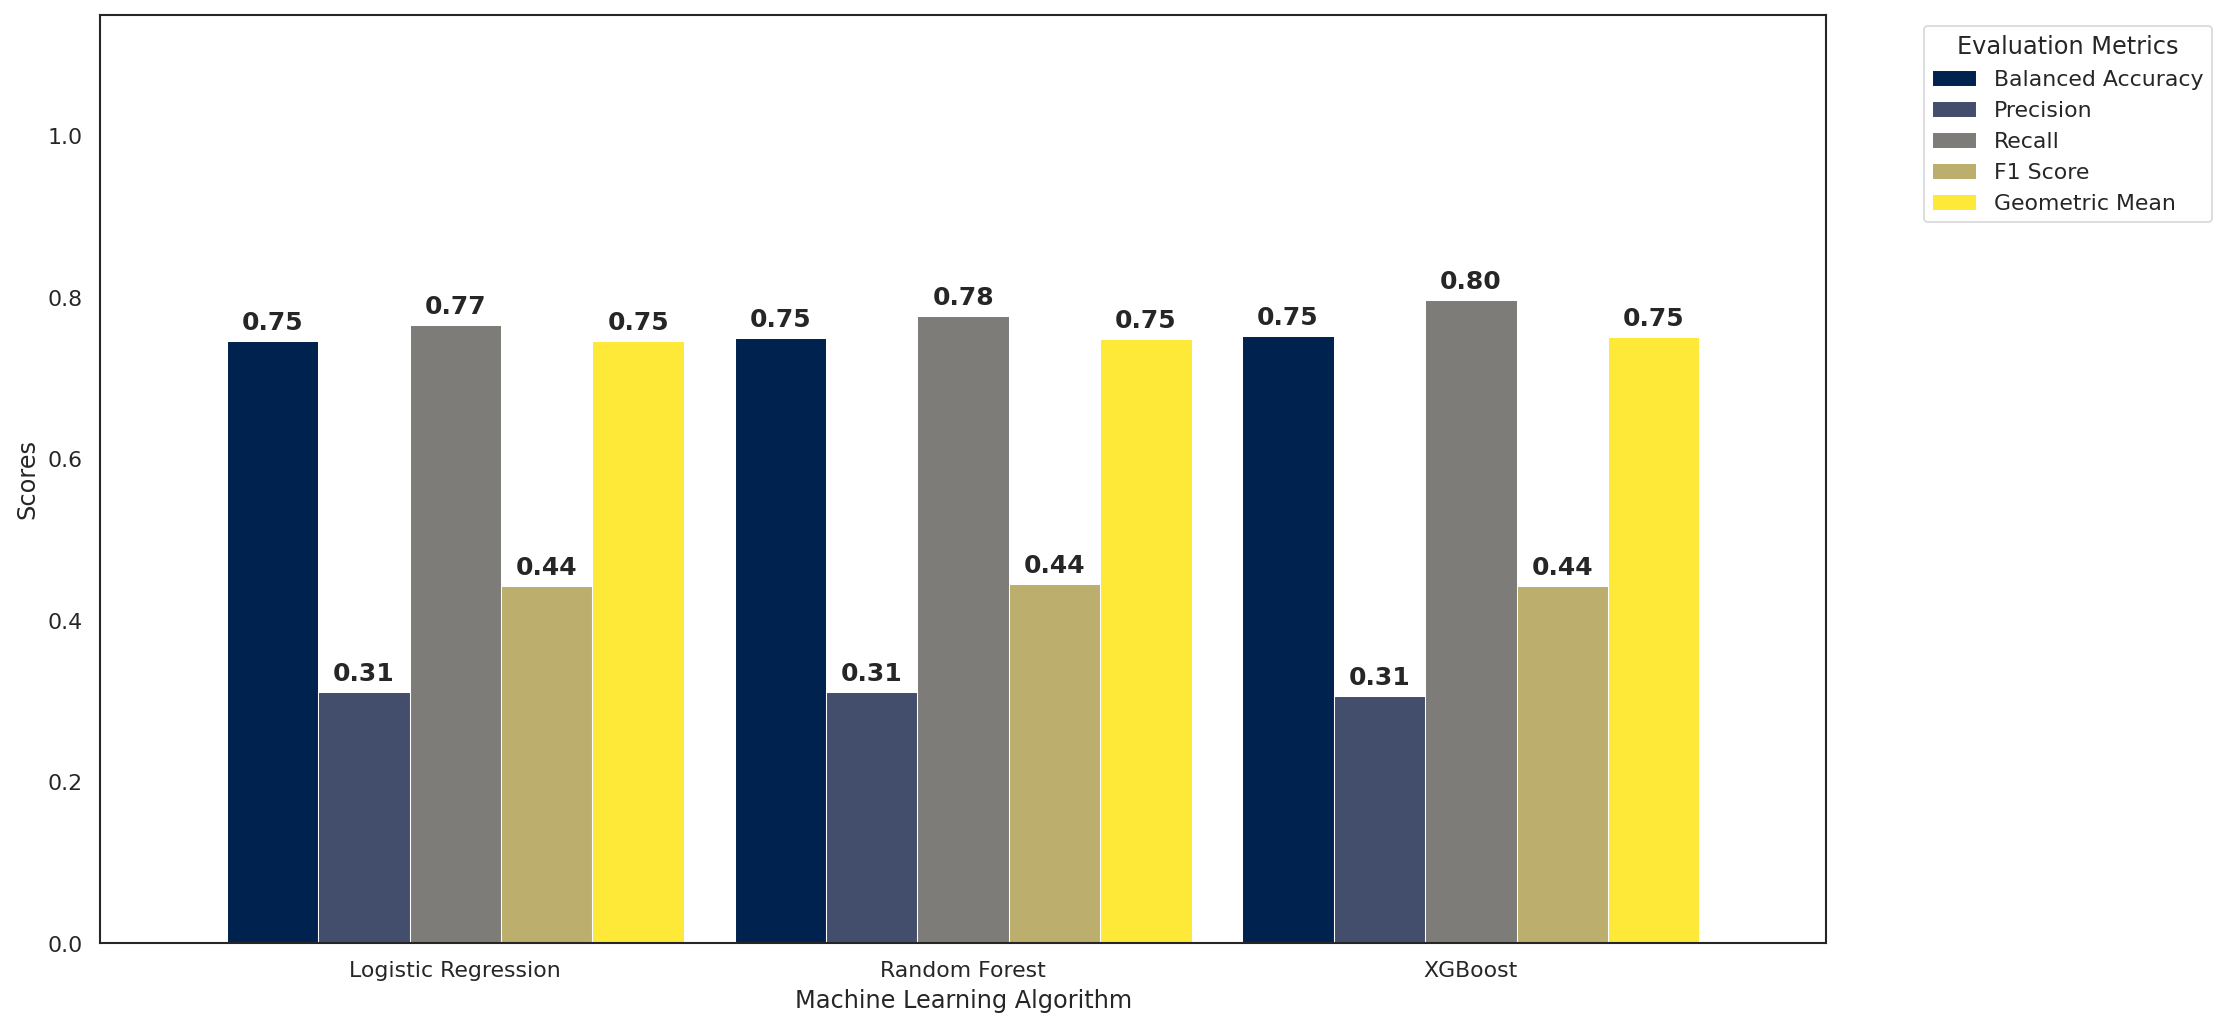

In [27]:
plot_df = metrics_df

fig, ax = plt.subplots(figsize=(15, 7))

plot_df.plot(kind="bar", ax=ax, cmap="cividis", edgecolor='white', linewidth=0.5, width=0.9)

for container in ax.containers:
    ax.bar_label(
        container,
        fmt='%.2f',
        padding=3,
        fontsize=12,
        fontweight='bold'
    )

print("Classifier Performance Comparison")
ax.set_ylabel("Scores")
ax.set_xlabel("Machine Learning Algorithm")
ax.set_ylim(0, 1.15)
plt.xticks(rotation=0)
plt.legend(title='Evaluation Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

base_name = "classifier_performance_results"
pdf_path = os.path.join(out_dir, f"{base_name}.pdf")
fig.savefig(pdf_path, bbox_inches="tight", pad_inches=0.02)

plt.show()
plt.close(fig)

### **Male vs. Female**

In [28]:
subgroups = {
    "Male": (X_test['Sex'] == 1),
    "Female": (X_test['Sex'] == 0)
}

final_gender_metrics = {}

for gender_name, mask in subgroups.items():
    results = {}

    X_sub = X_test[mask]
    y_sub = y_test[mask]

    for name, clf in classifiers.items():
        best_param = best_params.get(name)

        if best_param:
            clf = clf.set_params(**best_param)

            clf.fit(X_train, y_train)

            y_pred = clf.predict(X_sub)

            balanced_accuracy = balanced_accuracy_score(y_sub, y_pred)
            precision = precision_score(y_sub, y_pred)
            recall = recall_score(y_sub, y_pred)
            f1 = f1_score(y_sub, y_pred)
            geometric_mean = geometric_mean_score(y_sub, y_pred)

            results[name] = {
                "Balanced Accuracy": balanced_accuracy,
                "Precision": precision,
                "Recall": recall,
                "F1 Score": f1,
                "Geometric Mean": geometric_mean,
            }


    df = pd.DataFrame(results).T.reset_index().rename(columns={"index": "Classifier"})
    final_gender_metrics[gender_name] = df

for gender_name, df in final_gender_metrics.items():
    print(f"\n--- {gender_name} Results ---")
    display(df)
    print("\n")


--- Male Results ---


,Classifier,Balanced Accuracy,Precision,Recall,F1 Score,Geometric Mean
0,Logistic Regression,0.734103,0.310880,0.775317,0.443806,0.732945
1,Random Forest,0.737118,0.318851,0.767050,0.450455,0.736510
2,XGBoost,0.736994,0.302990,0.804842,0.440245,0.733865





--- Female Results ---


,Classifier,Balanced Accuracy,Precision,Recall,F1 Score,Geometric Mean
0,Logistic Regression,0.754482,0.312150,0.757740,0.442155,0.754475
1,Random Forest,0.759622,0.305081,0.785986,0.439550,0.759164
2,XGBoost,0.763196,0.308647,0.790060,0.443885,0.762724


### **Cross Validation**

In [29]:
num_folds = 5
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

In [30]:
train_subgroups = {
    "Overall": None,
    "Male": (X_train['Sex'] == 1),
    "Female": (X_train['Sex'] == 0)
}

final_cv_results = {}

for subgroup_name, mask in train_subgroups.items():
    subgroup_metrics = {}

    if mask is not None:
        X_cv = X_train[mask]
        y_cv = y_train[mask]
    else:
        X_cv = X_train
        y_cv = y_train

    for name, clf in classifiers.items():
        best_param = best_params.get(name)

        if best_param:
            clf = clf.set_params(**best_param)

            cv_scores = cross_val_score(clf, X_cv, y_cv, cv=kfold, scoring='balanced_accuracy')

            subgroup_metrics[name] = {
                "Mean Balanced Acc": np.mean(cv_scores),
                "Std Dev": np.std(cv_scores)
            }

    final_cv_results[subgroup_name] = pd.DataFrame(subgroup_metrics).T

for subgroup_name, df in final_cv_results.items():
    print(f"\n--- {subgroup_name} Cross-Validation Results ---")
    display(df.style.format("{:.4f}"))


--- Overall Cross-Validation Results ---


,Mean Balanced Acc,Std Dev
Logistic Regression,0.7455,0.0024
Random Forest,0.7488,0.0028
XGBoost,0.7519,0.0011



--- Male Cross-Validation Results ---


,Mean Balanced Acc,Std Dev
Logistic Regression,0.7321,0.0036
Random Forest,0.7337,0.0023
XGBoost,0.7364,0.0032



--- Female Cross-Validation Results ---


,Mean Balanced Acc,Std Dev
Logistic Regression,0.7577,0.0036
Random Forest,0.7598,0.0046
XGBoost,0.7614,0.0038


### **Explainable Artificial Intelligence**

**The Decision: XGBoost is my "Analysis Model"**


### **Initialize the SHAP Explainer**

In [31]:
shap.initjs()

In [34]:
best_classifier = XGBClassifier(**best_params["XGBoost"])
best_classifier.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, ...)

In [37]:
explainer = shap.TreeExplainer(best_classifier)
shap_values = explainer.shap_values(X_test)

shap_obj = shap_values

### **Generate Overall SHAP Summaries**

**Beeswarm plot**

Global Predictors of Diabetes Diagnosis (Total Population)


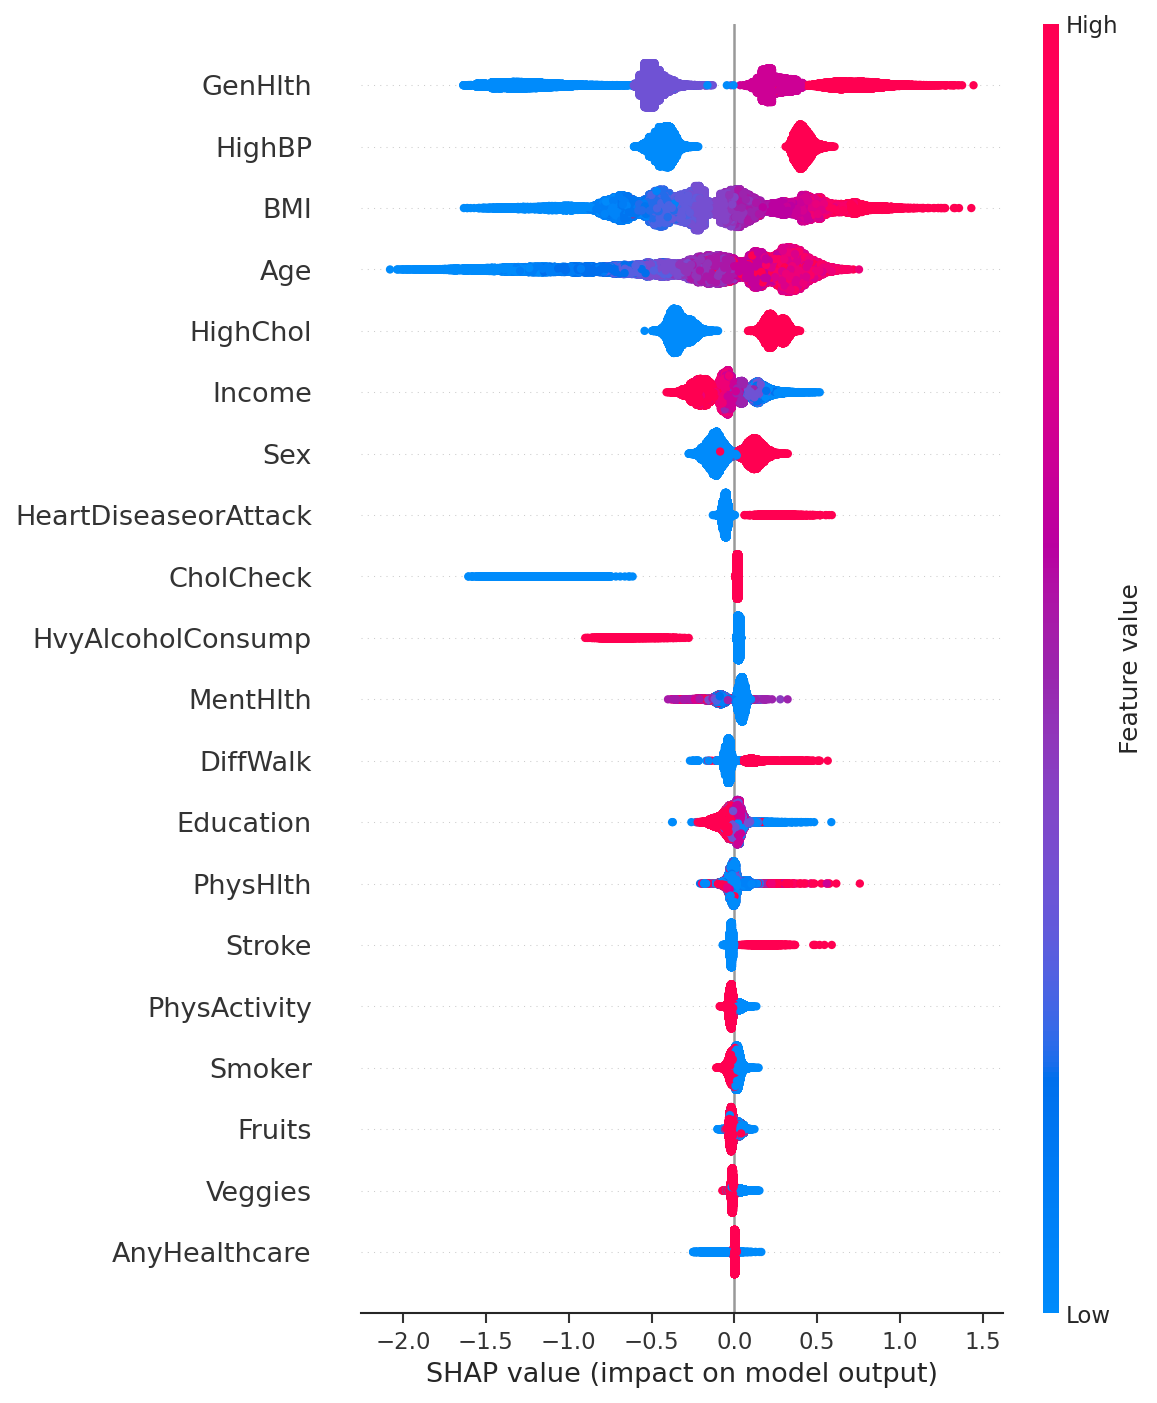

In [38]:
plt.figure(figsize=(12, 8))

shap.summary_plot(
    shap_obj,
    X_test,
    plot_type="dot",
    feature_names=X_test.columns.tolist(),
    show=False
)

print("Global Predictors of Diabetes Diagnosis (Total Population)")

plt.tight_layout()
plt.savefig(os.path.join(out_dir, "shap_summary_overall.pdf"), bbox_inches='tight')
plt.show()

### **Overall Feature Importance**

Global Feature Importance: All Respondents
(Mean Absolute SHAP Value)


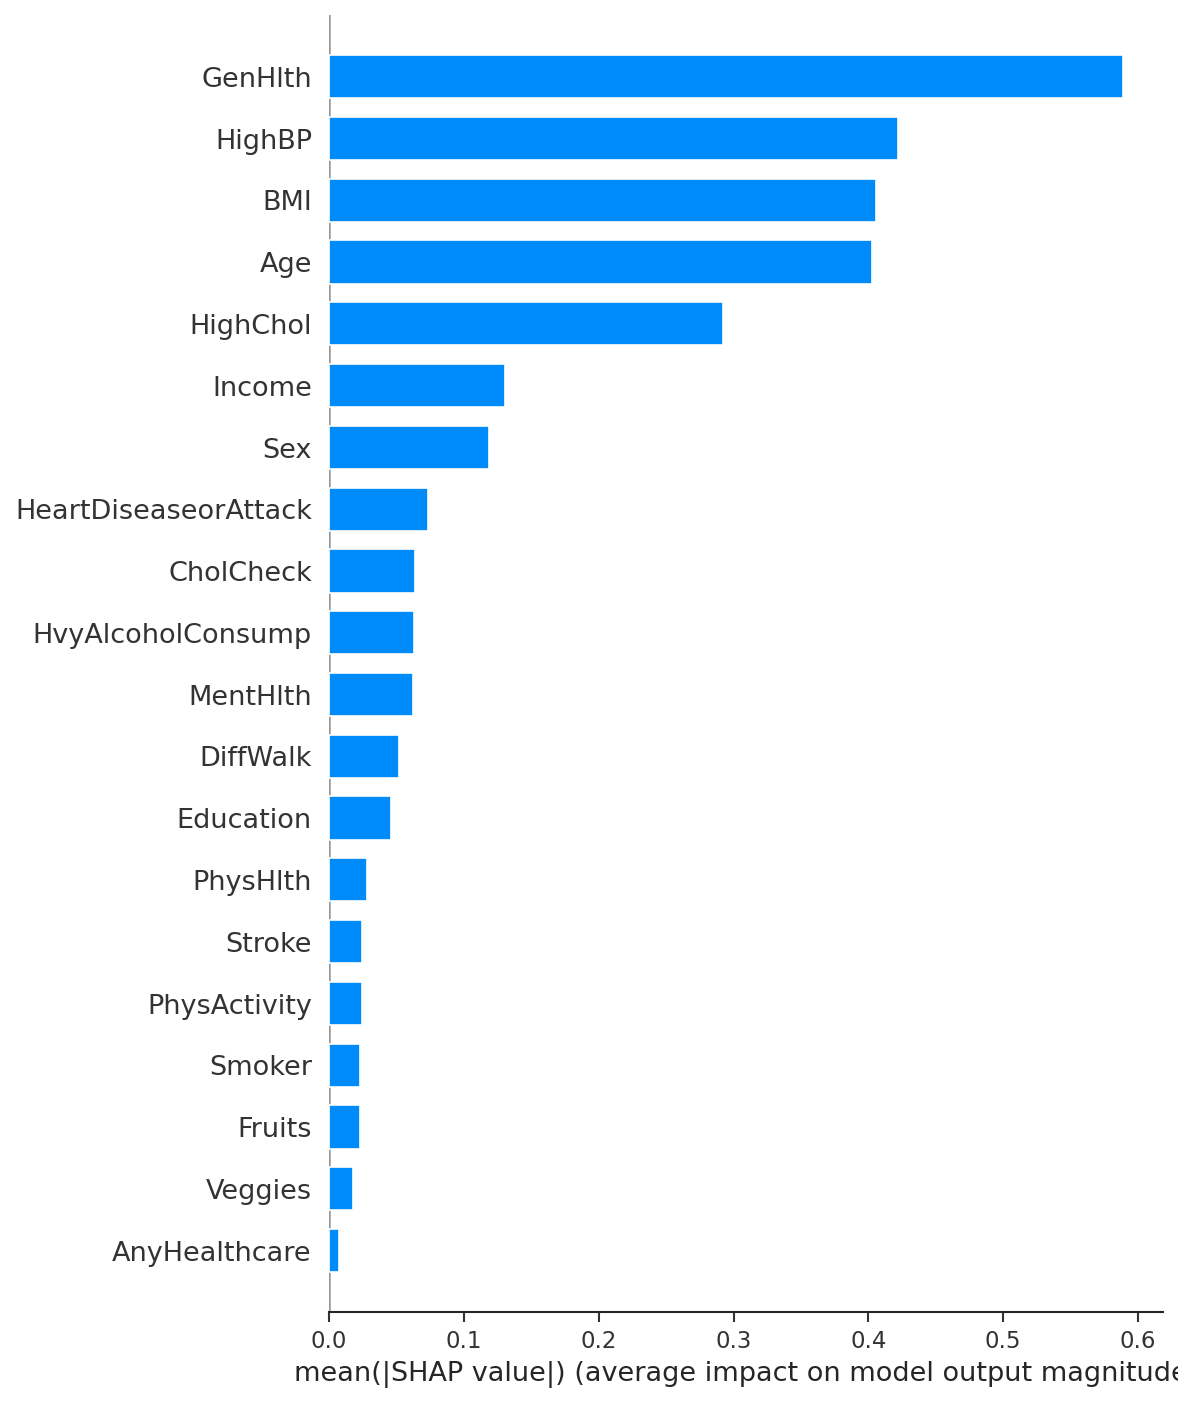

In [39]:
# --- Overall Plot (Mean Absolute SHAP) ---
plt.figure(figsize=(10, 6))

shap.summary_plot(
    shap_obj,
    X_test,
    plot_type="bar",
    show=False
)

print("Global Feature Importance: All Respondents\n(Mean Absolute SHAP Value)")

plt.tight_layout()
plt.savefig(os.path.join(out_dir, "shap_bar_overall.pdf"), bbox_inches='tight')
plt.show()

### **Generate Gender-Specific SHAP Summaries**

**Beeswarm plot**

Top Predictors of Diabetes Diagnosis (Male Respondents)


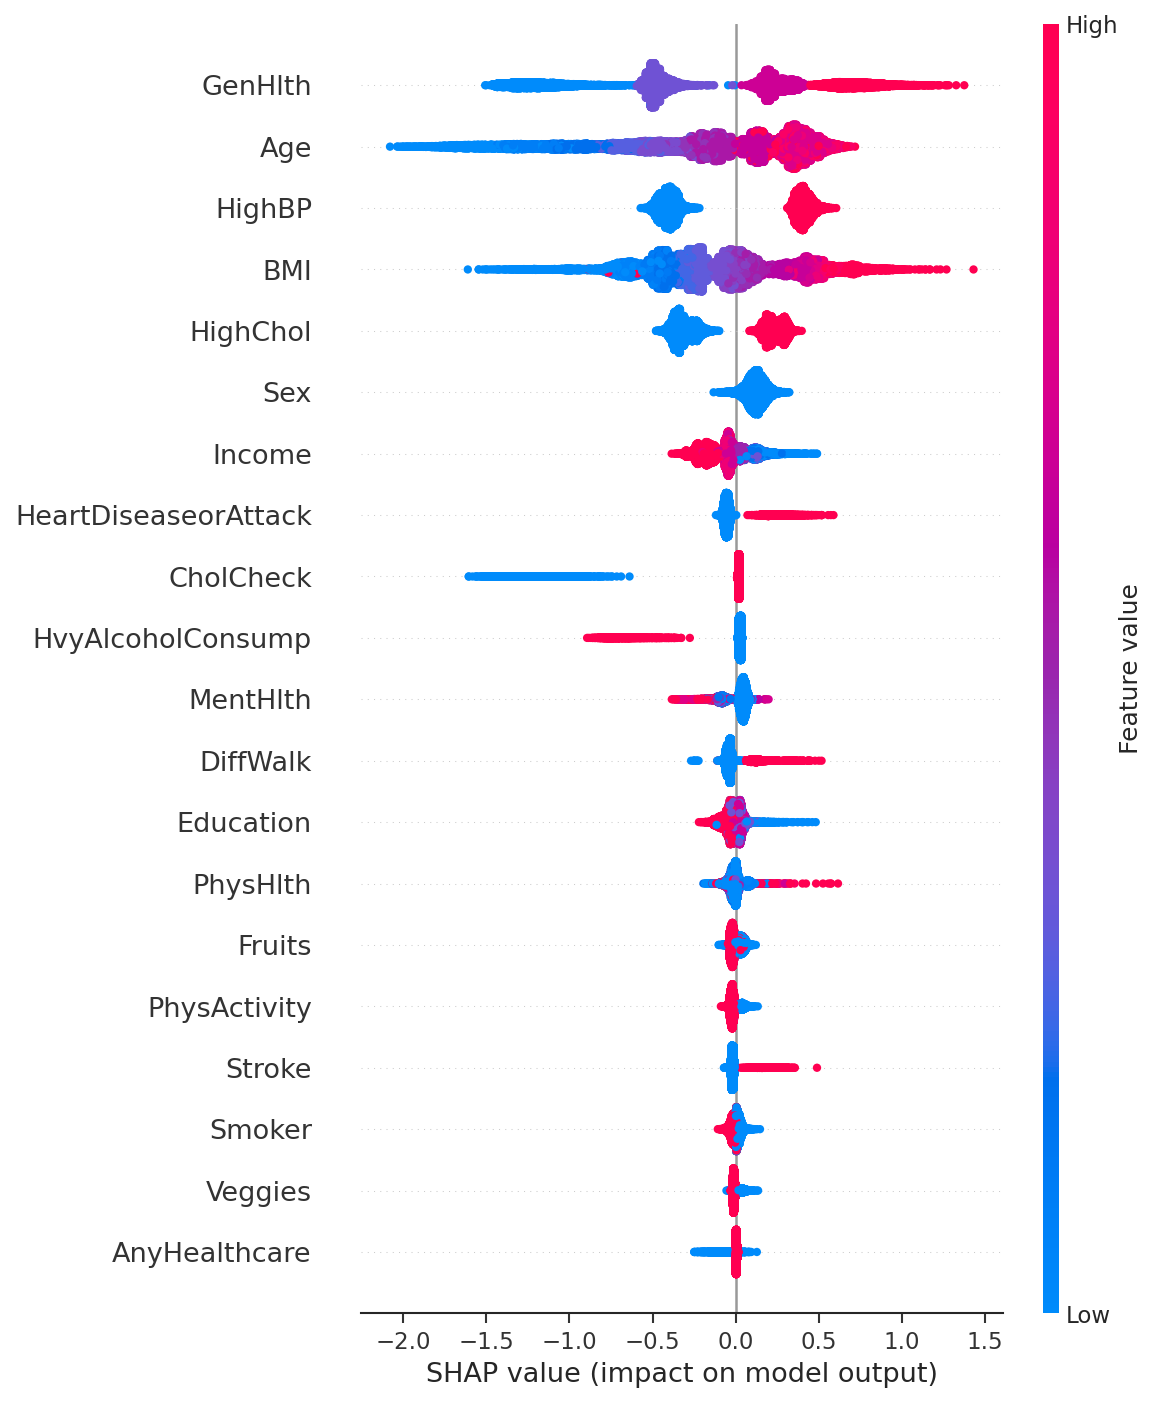

Top Predictors of Diabetes Diagnosis (Female Respondents)


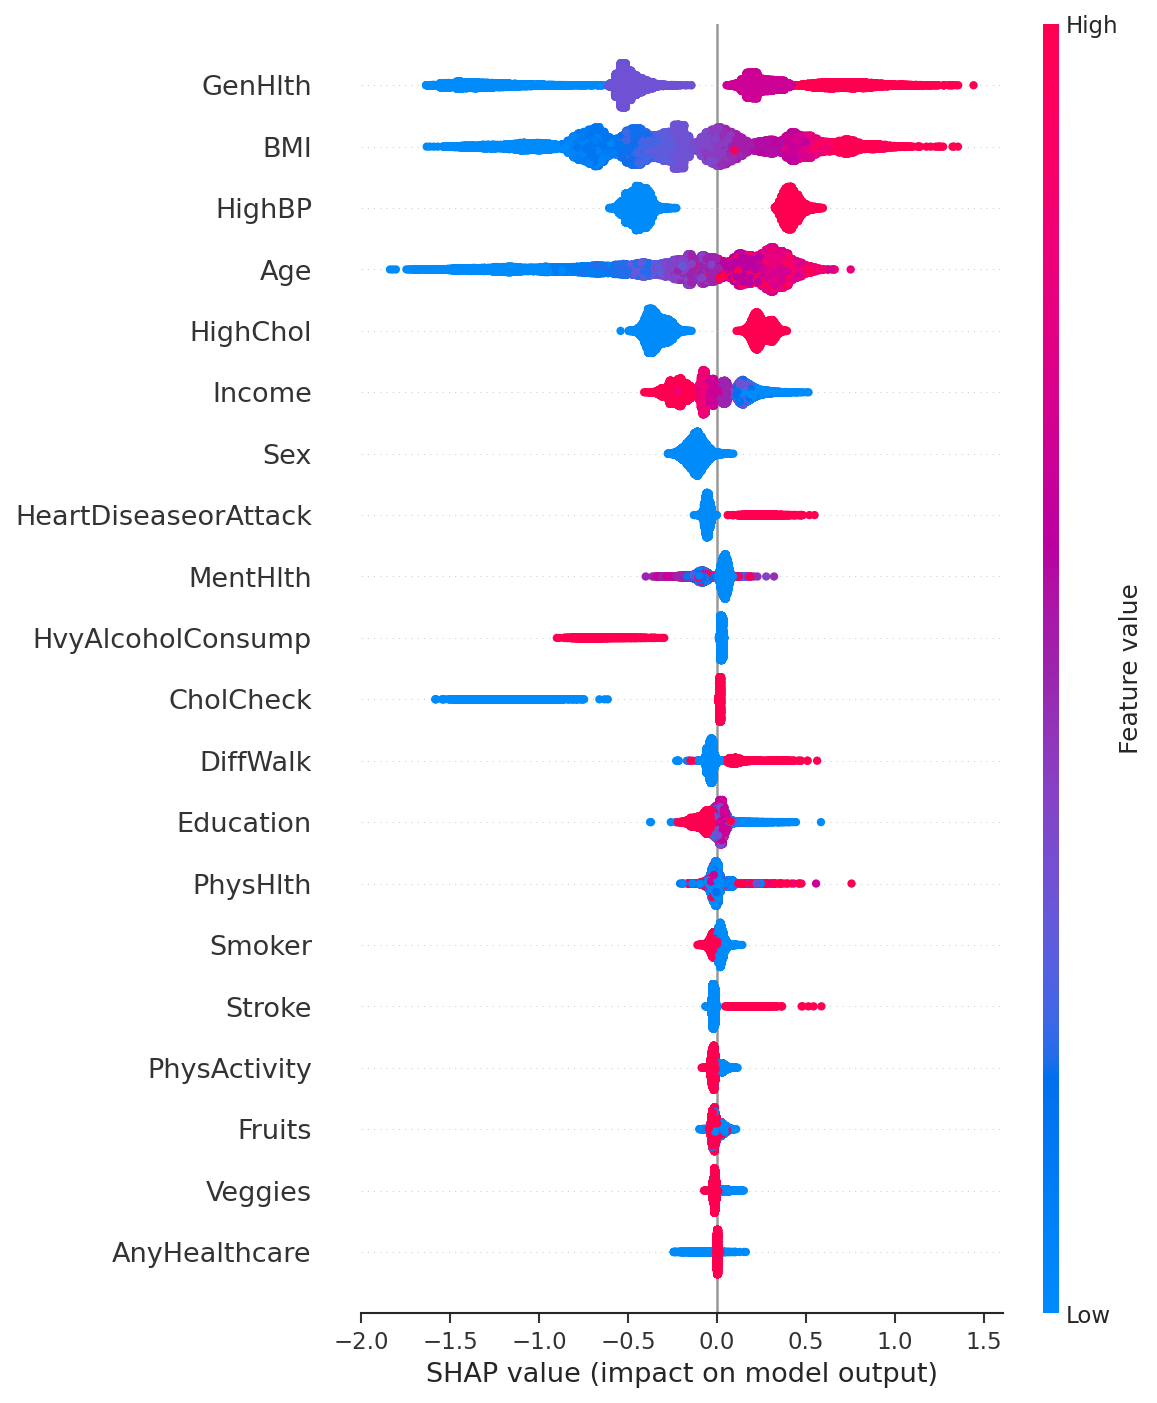

In [40]:
male_mask = (X_test['Sex'] == 1).values
female_mask = (X_test['Sex'] == 0).values

# Plot for Men
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_obj[male_mask],
    X_test[male_mask],
    plot_type="dot",
    feature_names=X_test.columns.tolist(),
    show=False,
    )

print("Top Predictors of Diabetes Diagnosis (Male Respondents)")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "shap_summary_male.pdf"))
plt.show()

# Plot for Women
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_obj[female_mask],
    X_test[female_mask],
    plot_type="dot",
    feature_names=X_test.columns.tolist(),
    show=False,
    )
print("Top Predictors of Diabetes Diagnosis (Female Respondents)")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "shap_summary_female.pdf"))
plt.show()

### **Gender-Specific Feature Importance**

Top Global Predictors: Male Respondents
(Mean Absolute SHAP Value)


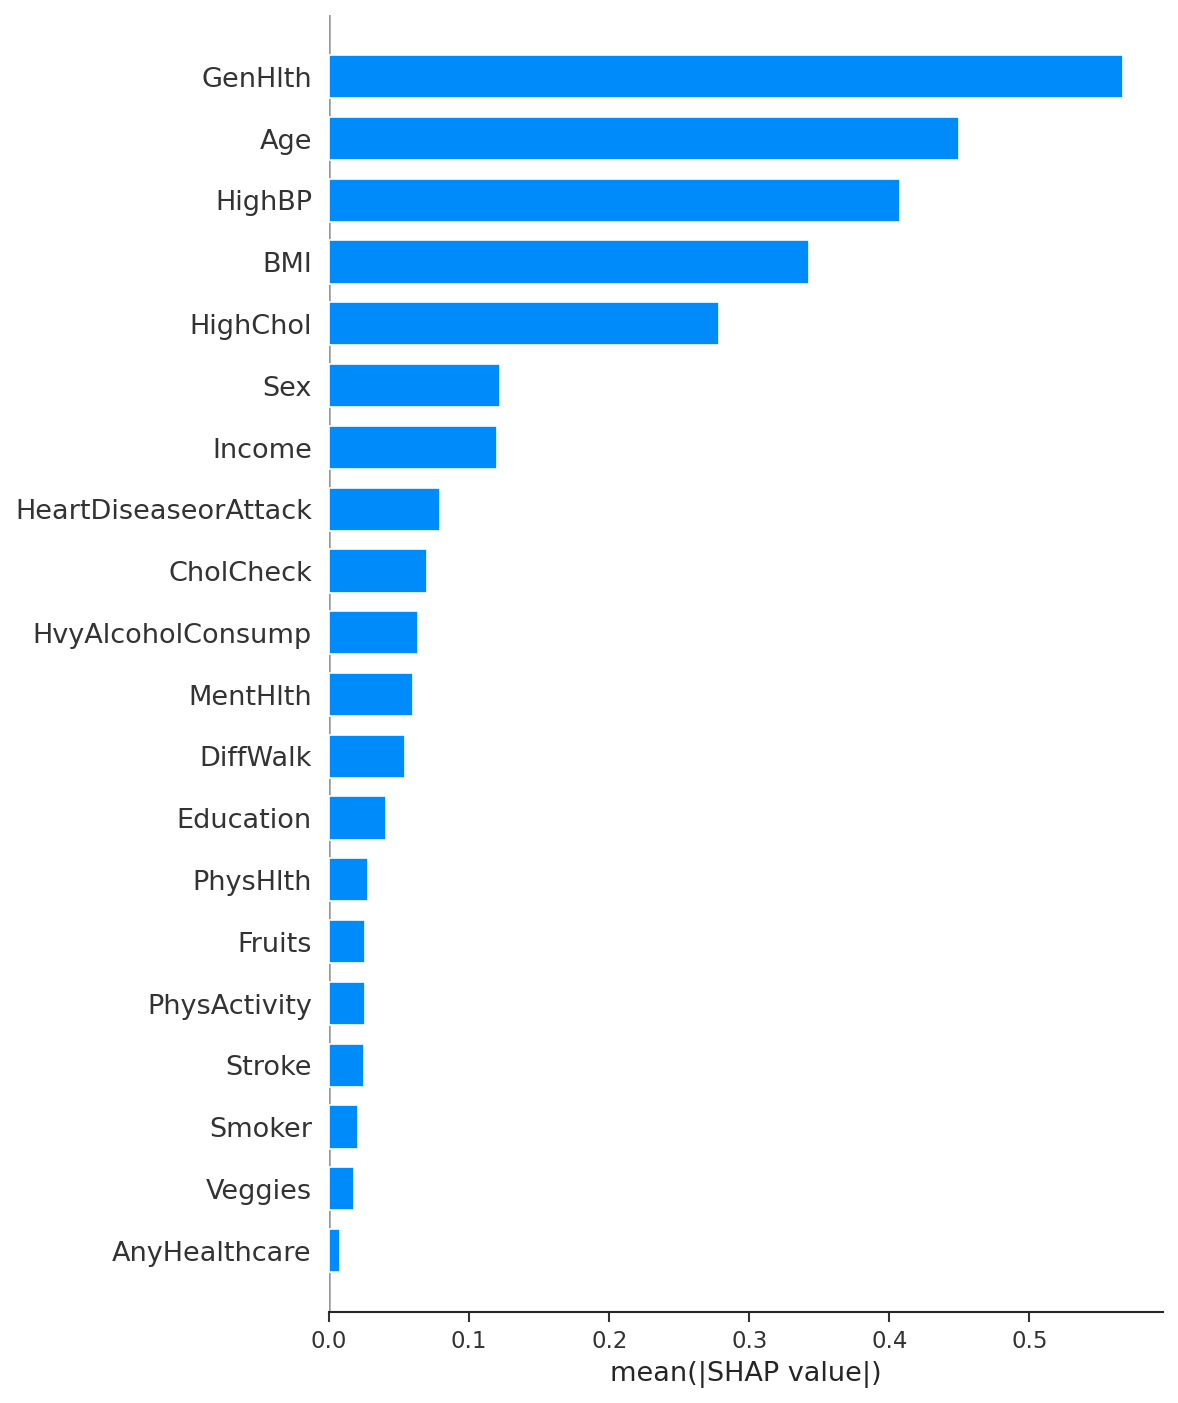

In [41]:
male_shap = shap_obj[male_mask]
female_shap = shap_obj[female_mask]

# --- PLOT FOR MALES ---
plt.figure(figsize=(10, 6))
shap.summary_plot(
    male_shap,
    X_test[male_mask],
    plot_type="bar",
    show=False
)

print("Top Global Predictors: Male Respondents\n(Mean Absolute SHAP Value)")

plt.xlabel("mean(|SHAP value|)")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "shap_bar_male.pdf"))
plt.show()

Top Global Predictors: Female Respondents
(Mean Absolute SHAP Value)


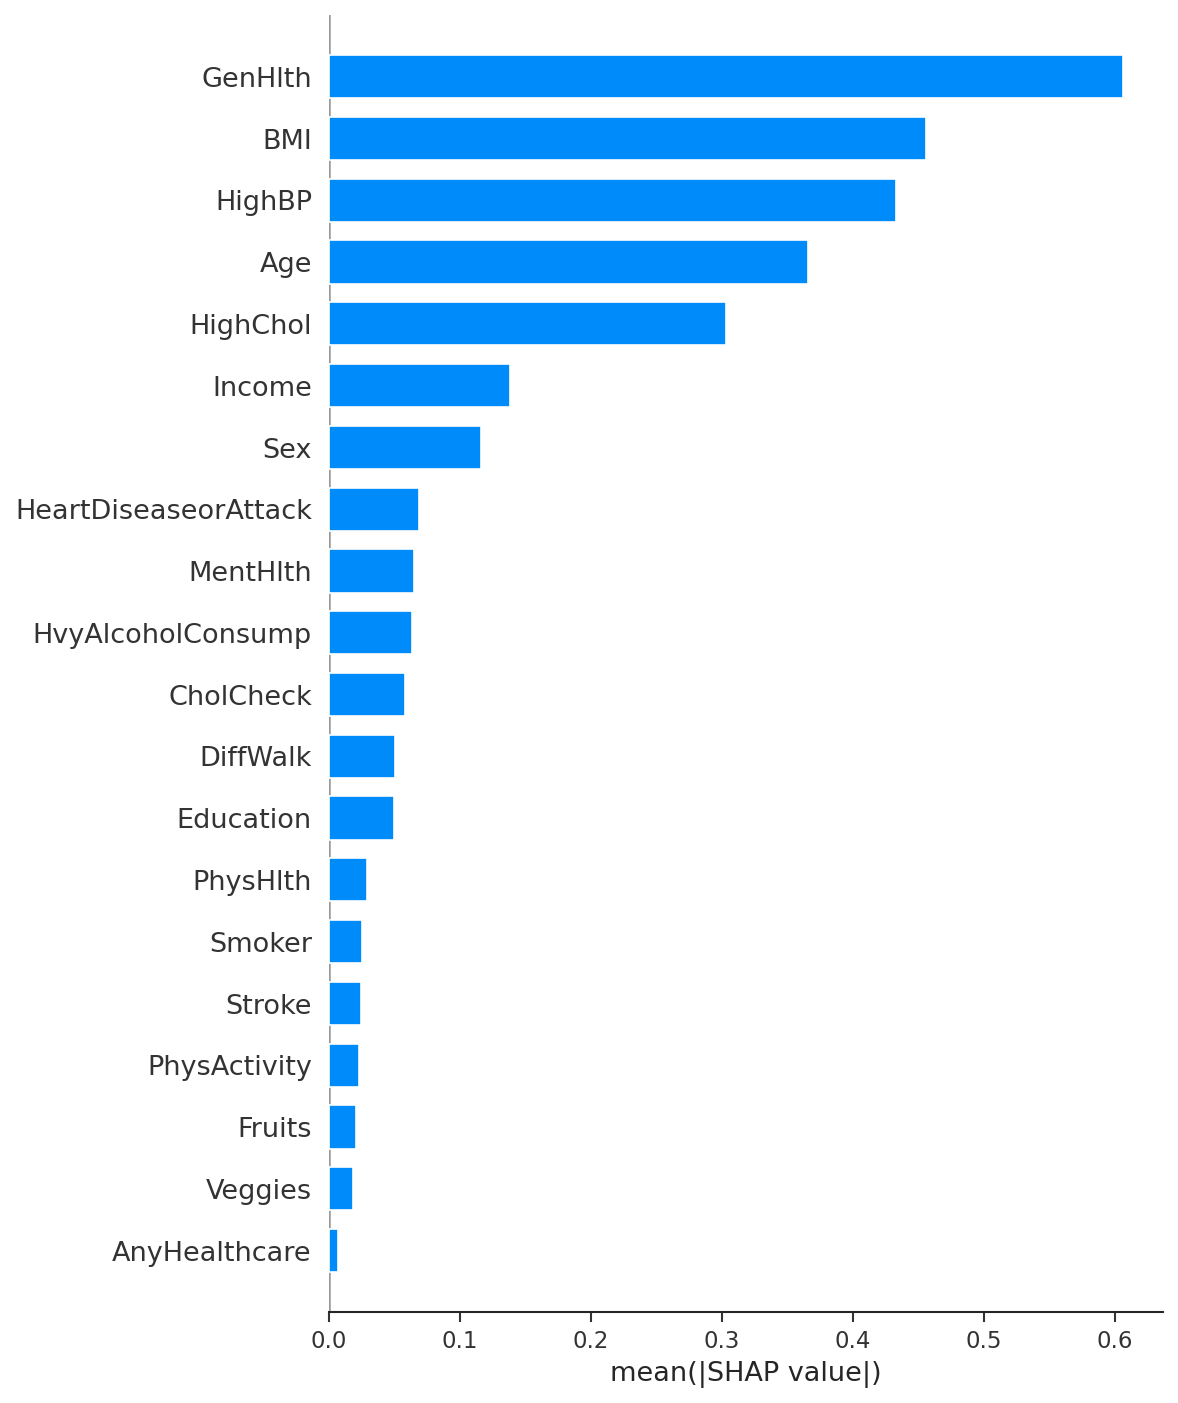

In [42]:
# --- PLOT FOR FEMALES ---
plt.figure(figsize=(10, 6))
shap.summary_plot(
    female_shap,
    X_test[female_mask],
    plot_type="bar",
    show=False
)

print("Top Global Predictors: Female Respondents\n(Mean Absolute SHAP Value)")

plt.xlabel("mean(|SHAP value|)")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "shap_bar_female.pdf"))
plt.show()